# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #007fd4"> Introduction</p>
Welcome to the Horse Health Multiclass Classification Prediction notebook! In this project, we will be working with a dataset that describes various aspects of Horse Health. The goal of this competition is to predict the final outcome for the Horse.

> This notebook mainly focuses not on getting a top score but rather on creating a notebook that has reliable accuracy with common techniques, including
 1. **OneHotEncoder**
 2. **OrdinalEncoder**
 3. **QuantileTransformer**
 4. **LazyPredict**
 5. **XGBClassifier**
 6. **LGBMClassifier**
 7. **VotingClassifier** 
 8. **Optuna hyperparameter framework**



In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename)) 


In [ ]:
pip install autofeatselect

In [ ]:
pip install lazypredict

In [ ]:
# Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import pprint
import warnings

# Data Preprocessing
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Feature Selection
from sklearn.feature_selection import mutual_info_classif
from autofeatselect import FeatureSelector

# Automated Model Selection
from lazypredict.Supervised import LazyClassifier

# Model Building
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Cross validation
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_val_predict

# Statistical Analysis
from scipy.stats import chi2_contingency

# Hyperparameter Tuning
import optuna

# Data Splitting
from sklearn.model_selection import train_test_split

# Metrices
from sklearn.metrics import confusion_matrix

In [ ]:
# ignore warnings
warnings.filterwarnings("ignore", category= UserWarning)
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [ ]:
# Define the style
rc = {
    "axes.facecolor": "#dcf5f7",
    "figure.facecolor": "#dcf5f7",
    "axes.edgecolor": "#000000",
    "grid.color": "#094863",
    "font.family": "arial",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4,
}
sns.set(rc=rc)

In [ ]:
# import the horse_health csv files
train = pd.read_csv('/kaggle/input/playground-series-s3e22/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e22/test.csv')

In [ ]:
# Create copies of the train and test DataFrames
df_train = train.copy()
df_test = test.copy()


# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #007fd4">Basic Data Exploration</p>

In [ ]:
# This will display all columns without truncation
pd.set_option('display.max_columns', None)

In [ ]:
df_train.sample(4)

In [ ]:
df_train.info()

In [ ]:
# Null values
columns_with_null_values = df_train.isnull().sum()
columns_with_null_values[columns_with_null_values > 0]

In [ ]:
df_train.describe(include="number")

In [ ]:
df_train.describe(include="object")

In [ ]:
# Null valuse percentage greater than 10%
columns_with_null_values_total = (df_train.isnull().sum() / len(df_train)) * 100
columns_with_null_values_percentage = columns_with_null_values_total[columns_with_null_values_total > 10].sort_values(ascending=False)

In [ ]:
columns_with_null_values_percentage

In [ ]:
def categories_validation(train, test):
    print("The categories mismatch in training and test dataset")
    categorical_features_test = test.select_dtypes(include=['object']).columns.to_list()

    equal_mismatch = []

    for feature in categorical_features_test:
        train_unique = set(train[feature].unique()) 
        test_unique = set(test[feature].unique())
        
        if train_unique != test_unique:
            equal_mismatch.append(feature)
            
    return equal_mismatch

mis_match = categories_validation(df_train, df_test)
mis_match


<div style="border-radius: 10px; border: #ffac00 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b> ⚠️ Inconsistent Columns:</b> Some columns contain inconsistent values that need to be addressed either manually or automatically by the pipeline.
</div>

In [ ]:
df_train_out = df_train.copy()

In [ ]:
# Map the 'outcome' column values to numerical values for classification
df_train_out['outcome'] = df_train_out['outcome'].map(
    {
        'lived': 2,   
        'euthanized': 1, 
        'died': 0  
    }
)

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:140%; text-align:left;padding: 10px; border-bottom: 3px solid #007fd4">Mutual Information</p>

<div style="border-radius: 6px; border: #004ed4 solid; padding: 26px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>📚 Mutual Information (MI) Score:</b> Mutual Information (MI) is a measure of the dependence between two random variables. It quantifies how much knowing one variable can tell you about another variable. A higher MI score indicates a stronger relationship or dependency between the feature and the target variable.
</div>


In [ ]:
mi_df = df_train_out.copy()

In [ ]:
def encding_numeric_categoric(dataframe):
    # Select numerical and categorical features
    numerical_features = dataframe.select_dtypes(include=[np.number])    
    categorical_features = dataframe.select_dtypes(include=['object', 'category'])
    
    # Fill missing values in numerical features with the median
    for col in numerical_features:
        dataframe[col].fillna(dataframe[col].median(), inplace=True)
    
    # Encode categorical features as numerical using factorization
    for col in categorical_features:
        dataframe[col], _ = dataframe[col].factorize()

<div style="border-radius: 10px; border: #0ea5e9 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>🖊️ Note :</b> Before evaluating the Mutual Information (MI) score, preprocessing is essential.
        <ul>
        <li>Select numeric columns</li>
        <li>Select categorical columns</li>
        <li>Fill NAN values in the numerical columns with <b>median</b></li>
        <li>Fill NAN values in the categirical columns with <b>factoriztion</b></li>
        <br>
        <li><b>Factorization :</b> Factorization assigns a unique numerical code to each distinct category or label in a categorical column.</li>
    </ul>
</div>

In [ ]:
# Apply encoding function to prepare the data
encding_numeric_categoric(mi_df)

# Extract the target variable 'outcome' and store it in 'mi_y'
mi_y = mi_df.pop("outcome")

In [ ]:
# Define a function to compute Mutual Information (MI) scores
def make_mi_score(X, y):
    
    # Compute MI scores for feature selection
    mi_score = mutual_info_classif(X, y, discrete_features='auto')
    
    # Create a Series to store MI scores with feature names
    mi_features = pd.Series(mi_score, name="MI Score", index=X.columns).sort_values(ascending=False)
    
    return mi_features

# Compute MI scores for the features in mi_df with respect to mi_y
mi_score = make_mi_score(mi_df, mi_y)
print(f"\033[34m{mi_score}")

In [ ]:
def plot_mi_score(score):
    
    # Define a colorful color palette for the bars
    colors = sns.color_palette('YlGnBu', n_colors=len(score))

    plt.figure(figsize=(13, 7))
    sns.barplot(x=score.values, y=score.index, orient='h', palette=colors)
    plt.title('Mutual Information Scores', color='black', fontweight='bold')
    plt.ylabel('Features', color='black', fontweight='bold')
    plt.xticks(rotation=40, color='red')

    # Add the value labels to the bars
    for index, value in enumerate(score.values):
        plt.text(value, index, f'{value:.2f}', color='black', ha='left', va='center')

    plt.tight_layout()  
    return plt.show()

plot_mi_score(mi_score)

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:140%; text-align:left;padding: 10px; border-bottom: 3px solid #007fd4">Auto Feature Selection</p>

<div style="border-radius: 6px; border: #004ed4 solid; padding: 26px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>📚 Auto Feature Selection:</b> <code>autofeatselect</code> is a Python library designed to automates feature selection process. It offers various methods for calculate the feature importance scores.

In [ ]:
X = df_train_out.drop('outcome', axis=1)
y = df_train_out['outcome']

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.9, random_state= 42)

In [ ]:
numerical_features = X.select_dtypes(include=[np.number]).columns.to_list()    
categorical_features = X.select_dtypes(include=['object', 'category']).columns.to_list()

In [ ]:
feat_selectors = FeatureSelector(modeling_type='classification',
                                 X_train=X_train, y_train=y_train,
                                 X_test=X_validation, y_test=y_validation,
                                 numeric_columns=numerical_features,
                                 categorical_columns=categorical_features,
                                 seed=42
                                )
print("\033[34m--- LightGBM Feature Importance ---")
lgbm_feature_importance = feat_selectors.lgbm_importance(hyperparam_dict=None, objective="multiclass", return_plot=True)
print("\033[34m--- XGB Feature Importance ---")
xgb_feature_importance = feat_selectors.xgb_importance(hyperparam_dict=None, objective="multiclass", return_plot=True)
print("\033[34m--- RandomForest Feature Importance ---")
xgb_feature_importance = feat_selectors.rf_importance(hyperparam_dict=None, return_plot=True)

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #007fd4">Exploratory Data Analysis</p>

In [ ]:
numerical_features = train.select_dtypes(include=[np.number])    
categorical_features = train.select_dtypes(include=['object', 'category'])

<div style="border-radius: 6px; border: #004ed4 solid; padding: 26px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>📚 Correation Heatmap:</b> The correlation heatmap is a valuable tool for gaining insights into your dataset, helping you identify relationships between variables, and potentially informing feature selection or further analysis.
    <ul>
        <li>A values close to 1 indicates a strong positive linear correlation, meaning that as one variable increases, the other also increases linearly.</li>
        <li>A values close -1 indicates a perfect negative correlation, meaning that as one variable increases, the other decreases linearly.</li>
        <li>A value of 0 indicates no linear correlation between the variables.</li>
    </ul>
</div>


In [ ]:
# Compute the correation matrix for numerical features
corr_matrix = df_train_out[numerical_features.columns].corr()
mask = np.triu(corr_matrix)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', mask=mask, linewidth=0.5, square=True, linecolor='#fafafa', fmt=".2f")

# Set plot title
plt.title('Correation Heatmap of Numerical Features', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')

plt.show()

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #007fd4">Chi-Squared Test</p>

<div style="border-radius: 6px; border: #004ed4 solid; padding: 26px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>📚 Chi-Squared Test:</b> The chi-squared test is a statistical hypothesis test used to determine if there is a significant association between two categorical variables. It is often used to assess whether there is a relationship between a categorical independent variables and the categorical dependent variable. The test is based on the differences between the expected and observed frequencies in a contingency table.
    <ul>
        <li><code>Null Hypothesis (H0)</code>: There is no significant association between the two categorical variables; they are independent.</li>
        <li><code>Alternative Hypothesis (H1)</code>: There is a significant association between the two categorical variables; they are dependent.</li>
        <li><code>crosstab</code>: Construct a contingency table that summarizes the observed counts of the data and Calculate the expected frequencies for each cell in the contingency table under the assumption that the variables are independent</li>
        <li><code>chi-squared</code>: Calculate the difference between the observed and expected frequencies.</li>
        <li><code>p-value</code>: Calculate the p-value associated with the test statistic. The p-value represents the probability of observing a test statistic
        <br><br>
        <li>Compare the p-value to a predetermined significance level (e.g., 0.05). If the p-value is less than the significance level, reject the null hypothesis that means there is significant association between the two categorical variables. If there is no significant association between the two categorical variables null hypothesis is accepted. So based on this we can exclude the features that have values <b>higher than the predetermined significance level.</b></li>
</div>

In [ ]:
#  Select categorical features with a moderate number of unique values
value_counts = df_train.nunique()
categorical_values = value_counts[(value_counts > 1) & (value_counts < 20)].index.tolist()
categorical_features_chi = list(set(categorical_values) - set(['outcome']))

In [ ]:
threshold = 0.05

print(f'{"Columns":<26} | {f"Test score":<26}| Test result')
print("-" * 69)

for feature in categorical_features_chi:
    
    # Create a contingency table
    contingency_table = pd.crosstab(df_train["outcome"], df_train[feature])
    
    # Perform the chi-squared test
    chi2, p, _, _ = chi2_contingency(contingency_table)

    if p < threshold:
        print(f"\033[32m{feature:<28}{p:<28}Passed")
    else:
        print(f"\033[31m{feature:<28}{p:<28}Failed")

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #007fd4">Numerical Features Data Exploration</p>

#### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:140%">Numerical Features Distribution</p>

In [ ]:
# Exclude 'id' and 'hospital_number'
numerical_features_distribution = list(set(numerical_features.columns) - set(['id', 'hospital_number', 'lesion_3'])) 

In [ ]:
 # Number of columns in each row
num_cols = 2 

# Calculate the number of rows needed
num_rows = (len(categorical_features.columns) + 1) // num_cols  

# Create a figure with a specific size for subplots
plt.figure(figsize=(12, 26)) 

for i, feature in enumerate(numerical_features_distribution, start=1):
    plt.subplot(num_rows, num_cols, i) 
    sns.histplot(data=df_train, x=feature, hue='outcome', palette="YlGnBu", multiple="stack", kde=True, bins=30, shrink=0.9)
    plt.title(f'Distribution for {feature}outcome', fontsize=12, fontweight='bold')
    plt.xlabel(feature, fontsize=10)
    plt.ylabel('Frequency', fontsize=10)

# Ensure proper spacing between subplots
plt.tight_layout(h_pad=2.6)  
plt.show()


#### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:140%">Numerical Features Outliers</p>

In [ ]:
# Numerical features
for feature in numerical_features_distribution:

    plt.figure(figsize=(13,4))
    plt.subplot(1,2,1)
    sns.boxenplot(data=df_train, x='outcome', y=feature, palette="YlGnBu")
    plt.title(f' Outlier Detection for {feature} in training dataset', fontsize=12, fontweight='bold')
    plt.xlabel('Outcome', fontsize=10)
    plt.ylabel(feature, fontsize=10)

    plt.subplot(1,2,2)
    sns.boxenplot(data=df_test, y=feature, palette="YlGnBu")
    plt.title(f' Outlier Detection for {feature} in testing dataset', fontsize=12, fontweight='bold')
    plt.xlabel('Outcome', fontsize=10)
    plt.ylabel(feature, fontsize=10)

    plt.show()

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #007fd4">Categorical Features Data Exploration</p>

In [ ]:
num_cols = 2  # Number of columns in each row
num_rows = (len(categorical_features.columns) + 1) // num_cols  # Calculate the number of rows needed

plt.figure(figsize=(12, 26))

for i, feature in enumerate(categorical_features.columns, start=1):
    plt.subplot(num_rows, num_cols, i) 
    sns.histplot(data=df_train, x=feature, hue='outcome', palette="YlGnBu", multiple="stack", shrink=0.8)
    plt.title(f' Frequency Table for {feature} and the outcome', fontsize=12, fontweight='bold')
    plt.xlabel(feature, fontsize=10)
    plt.ylabel('Frequency', fontsize=10)

plt.tight_layout(h_pad=2.6)  # Ensure proper spacing between subplots
plt.show()


In [ ]:
features_name = df_train['outcome'].value_counts().index
features_values = df_train['outcome'].value_counts().values

colors = sns.color_palette('YlGnBu')

plt.figure(figsize=(8, 6)) 
plt.pie(features_values, labels=features_name, colors=colors, autopct='%1.1f%%', startangle=70, counterclock=False)

plt.title('Outcome Distribution', fontweight='bold')

plt.show()

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #007fd4">Data Engineering</p>

In [ ]:
df_train_full = df_train_out.copy()
df_test_full = df_test.copy()

In [ ]:
# columns to be dropped
columns_to_drop = ['id', 'lesion_3']

<div style="border-radius: 10px; border: #0ea5e9 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>🖊️ Note :</b> Address the previously findout inconsistency columns.
        <ul>
        <li>In the testing dataset, "slight" is referred to as "moderate", so we replace all values in the training dataset pain column from "slight" to "moderate" and so to the other inconsistency columns based on there values.</li>
    </ul>
</div>

In [ ]:
df_train_full["pain"] = df_train_full["pain"].replace('slight', 'moderate')
df_train_full["peristalsis"] = df_train_full["peristalsis"].replace('distend_small', 'normal')
df_train_full["rectal_exam_feces"] = df_train_full["rectal_exam_feces"].replace('serosanguious', 'absent')
df_train_full["nasogastric_reflux"] = df_train_full["nasogastric_reflux"].replace('slight', 'none')

In [ ]:
df_train_full.drop(columns=columns_to_drop, axis=1, inplace=True)
df_test_full.drop(columns=columns_to_drop, axis=1, inplace=True)

In [ ]:
# Columns length
print(f"Length of the training dataset is {df_train_full.shape[1]}")
print(f"Length of the testing dataset is {df_train_full.shape[1]}")

In [ ]:
categorical_features = df_train_full.select_dtypes(include=['object', 'category']).columns.to_list()
pprint.pprint(categorical_features, compact=True)

print((f"\n Categorical column count in the training dataset :{len(categorical_features)}"))

In [ ]:
numerical_features = df_train_full.select_dtypes(include=[np.number]).columns.to_list()
pprint.pprint(numerical_features, compact=True)

print((f"\n Numerical column count in the training dataset :{len(numerical_features)}"))

In [ ]:
for feature in categorical_features:
    print(f"{feature:<36} - {df_train_full[feature].unique()}")

In [ ]:
df_train_pipeline_1 = df_train_full.copy()
df_test_pipeline_1 = df_test_full.copy()

<div style="border-radius: 10px; border: #0ea5e9 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>🖊️ Note :</b> <code>Ordinal features</code> are a type of categorical feature that have a specific order or ranking among them. These features represent characteristics that can be ordered or ranked into distinct categories.
</div>

<div style="border-radius: 10px; border: #0ea5e9 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>🖊️ Note :</b> <code>Ordinal mapping</code> is a technique used in data preprocessing,  which converts categorical or ordinal features with meaningful orderings into numerical values. These numerical values retain the inherent ordinal relationship between categories. By using these mappings, we preserve the ordinal relationships between categories, which can be crucial for certain models to make meaningful predictions.
</div>

In [ ]:
# Define ordinal mappings
ordinal_mappings = {
    'temp_of_extremities': {'cool': 0, 'cold': 1, 'normal': 2, 'warm': 3},
    'peripheral_pulse': {'absent': 0, 'reduced': 1, 'normal': 2, 'increased': 3},
    'capillary_refill_time': {'less_3_sec': 0, '3': 1, 'more_3_sec': 2},
    'pain': {'moderate': 0, 'mild_pain': 1, 'alert': 2, 'depressed': 3, 'severe_pain': 4, 'extreme_pain': 5},
    'abdominal_distention': {'none': 0, 'slight': 1, 'moderate': 2, 'severe': 3},
    'nasogastric_tube': {'none': 0, 'slight': 1, 'significant': 2},
    'nasogastric_reflux': {'none': 0, 'slight': 1, 'less_1_liter': 2, 'more_1_liter': 3}
}

In [ ]:
ordinal_features = ['temp_of_extremities', 'peripheral_pulse', 'capillary_refill_time', 'pain', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux']

<div style="border-radius: 10px; border: #0ea5e9 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>🖊️ Note :</b> <code>Nominal features</code> are a type of categorical features, but it do not have any inherent order or ranking among them. These features describe characteristics that can be divided into distinct groups or classes.
</div>

In [ ]:
nominal_features = list(set(categorical_features) - set(ordinal_features))
pprint.pprint(nominal_features, compact=True)

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #007fd4">Pipelines</p>

<div style="border-radius: 6px; border: #004ed4 solid; padding: 26px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>📚 Pipelines:</b> Pipelines are a simple way to  encapsulating the entire data preprocessing workflow in to a single object. Pipelines are valuable for organization, reproducibility, and modularity while helping to avoid common pitfalls like data leakage. By encapsulating all the necessary steps in one object, pipelines simplify the process of developing, evaluating, and model deploying process.
    <ul>
    <br>
        <li><b>QuantileTransformer</b> : Applying a quantile transformation facilitates the conversion of numerical features into a normal distribution, potentially enhancing their adherence to Gaussian characteristics and it can be advantageous for certain machine learning algorithms.</li>
        <br>
        <li><b>StandardScaler</b> : Applying a standardizer scales the numerical features to have a mean of 0 and a standard deviation of 1. It ensures that all numerical features have the same scale, which is important for many machine learning algorithms.</li>
        <br>
        <li><b>OrdinalEncoder</b> : Converts ordinal categorical data into a numeric format, preserving the order of categories by mapping of category labels to integer values.</li>
        <br>
        <li><b>OneHotEncoder</b>: Converts the categorical values into binary vectors.</li>
</div>

In [ ]:
# Create pipeline with function transformer and the preprocessor

numerical_features
ordinal_features
nominal_features

# Remove the target variable
numerical_cols = numerical_features
numerical_cols.remove("outcome")

categories_list = [list(ordinal_mappings[key].values()) for key in ordinal_mappings]

# Preprocessing step for numerical columns
numerical_transformer = Pipeline(steps=[
    ('quantileTransformer', QuantileTransformer(output_distribution="normal", random_state=42)),
    ('scaler', StandardScaler())
])

# Preprocessing step for ordinal columns
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1, categories=categories_list))
])

# Preprocessing step for nominal columns
nominal_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Combine both transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('ordinal', ordinal_transformer, ordinal_features),
        ('onehot', nominal_transformer, nominal_features)
    ], remainder="passthrough"
)

pipeline_fe_ohe_ordinal = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

pipeline_fe_ohe_ordinal

<div style="border-radius: 10px; border: #0ea5e9 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>🖊️ Note :</b> Instead of imputing missing values, allowing XGBoost and LightGBM to handle them can lead to more accurate predictions in certain scenarios. However, there are situations where applying imputation techniques can be advantageous. Here, we allow XGBoost and LightGBM to handle the missing values, and there's no need to include imputation techniques in the pipeline.
</div>

In [ ]:
X = df_train_pipeline_1.drop("outcome", axis=1)
y = df_train_pipeline_1["outcome"]

In [ ]:
# Fit and transform the training data using the preprocessing pipeline
X_preprocessed_pipeline1 = pipeline_fe_ohe_ordinal.fit_transform(X)

# Transform the test data using the same preprocessing pipeline
X_test_preprocessed_pipeline1 = pipeline_fe_ohe_ordinal.transform(df_test_pipeline_1)

<div style="border-radius: 10px; border: #0ea5e9 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>🖊️ Note :</b> In pipelines, <code>fit_transform</code> and <code>transform</code> are two distinct concepts. The <code>fit</code> step enables the transformer to learn the necessary parameters for data preprocessing, while the <code>transform</code> step applies these learned parameters to the data. The separation of fitting and transforming is crucial because it ensures that preprocessing is based on statistics and parameters acquired from the training data. Applying the same transformation to test data using the learned parameters maintains consistency and prevents data leakage.
    <br>
    <ul>
        <li><code>fit_transform</code> : Learns the parameters required for transformation from the training data and then applies these learned parameters to the training data.</li>
        <li><code>transform</code> : Utilizes the parameters acquired during the fitting step to perform the transformation on the testing data.</li>
    </ul>
</div>

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X_preprocessed_pipeline1, y, train_size=0.9, random_state=42)

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #007fd4">Model Building</p>

<div style="border-radius: 6px; border: #004ed4 solid; padding: 26px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>📚 LazyClassifier :</b> A tool that can swiftly gain insights into various models' performance on a specific problem without spending a significant amount of time on model selection.
</div>

In [ ]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
model, prediction = clf.fit(X_train, X_validation, y_train, y_validation)
model

<div style="border-radius: 6px; border: #004ed4 solid; padding: 26px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>📚 Cross validation:</b> Cross validation helps in assessing the model's generalization performance.
    <ul>
    <br>
        <li><b>StratifiedKFold :</b> Maintains the class distribution in each fold. It ensures that each fold has roughly the same proportion of each class as the original dataset. It is particularly useful when dealing with imbalanced datasets, where some classes may have significantly fewer instances than others. It helps prevent issues where a fold might end up with very fewer instances of a particular class.</li>
        <br>
        <li><b>RepeatedStratifiedKFold :</b> Extension of StratifiedKFold with added repetition. It involves repeatedly applying StratifiedKFold 'n' times, each time with different random shuffling of the data before creating the folds. This approach aims to reduce the impact of the initial random data split on the performance estimation, making the cross validation results more robust and reliable.</li>
        <br>
</div>

In [ ]:
RepStratFold = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=42)

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #007fd4">Optuna Hyperparameter Tunning</p>

<div style="border-radius: 6px; border: #004ed4 solid; padding: 26px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>📚 Bayesian Optimization :</b> Hyperparameters are configuration settings that are not learned from the data but are set prior to training a model. The process of finding the optimal combination of these hyperparameters is known as hyperparameter optimization, and it can have a significant impact on performance.

There are several techniques used to find the best hyperparameters for models. <code>Grid Search</code> and <code>Randomized Search</code> are some of them, but Grid Search lacks the ability to adapt its search based on previous evaluations, so it may miss out on fine-tuning opportunities in the search space. Randomized Search is better than Grid Search in exploring the space but still lacks an adaptive mechanism. <code>Bayesian optimization</code>, on the other hand, balances exploration (searching different hyperparameters) and exploitation (focusing on promising areas), making it more likely to find the global optimum with fewer trials.

Bayesian optimization builds a probabilistic model of the objective function and selects the next set of hyperparameters based on the model's predictions. This makes it more efficient as it focuses on promising regions of the search space, reducing the number of evaluations needed to find better hyperparameters.
</div>

In [ ]:
# Define a function to optimize hyperparameters for different machine learning models using Optuna
"""
def objective(trial, model_name):
    if model_name == 'xgboost':
        # Define hyperparameters to optimize for XGBoost
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1024),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'max_depth': trial.suggest_int('max_depth', 1, 20),
            'booster': trial.suggest_categorical('booster', ['gbtree']),
            'objective': trial.suggest_categorical('objective', ['multi:softmax']),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_float('gamma', 0.1, 1),
            'subsample': trial.suggest_float('subsample', 0.1, 1),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 0.5),
            'eval_metric': 'mlogloss',
            'random_state': 42
        }
        clf = XGBClassifier(**params)

    elif model_name == "lgbm":
        # Define hyperparameters to optimize for LightGBM
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1024),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
            'objective': 'multiclass',
            'metric': 'multi_logloss',
            'max_depth': trial.suggest_int('max_depth', 1, 20),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'subsample': trial.suggest_float('subsample', 0.01, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.01, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.01, 1.0),
            'lambda_l1': trial.suggest_float('lambda_l1', 0.0001, 1.0),
            'lambda_l2': trial.suggest_float('lambda_l2', 0.0001, 1.0),
            'verbose': -1,
            'bagging_freq': 3,
            'random_state': 42
        }
        clf = LGBMClassifier(**params)

    elif model_name == "random_forest":
        # Define hyperparameters to optimize for Random Forest
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1024),
            'max_depth': trial.suggest_int('max_depth', 1, 20),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.01, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.01, 0.5),
            'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
            'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
            'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
            'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.0, 0.2),
            'random_state': 42
        }
        clf = RandomForestClassifier(**params)

    else:
        raise ValueError("Invalid model_name")

    # Use cross-validation to evaluate the model with the selected hyperparameters
    scores = cross_val_score(clf, X_preprocessed_pipeline1, y, cv=RepStratFold)
    accuracy = scores.mean()

    return accuracy

def models(model_names):
    # List to store the best hyperparameters for each model
    model_hyperparameters = []

    for model in model_names:

        # Create an Optuna study to optimize hyperparameters for the current model
        study = optuna.create_study(direction='maximize')

        # Optimize the model's hyperparameters using the 'objective' function
        study.optimize(lambda trial: objective(trial, model), n_trials=30, n_jobs=-1, show_progress_bar=True)
        
        # Get the best hyperparameters and accuracy for the current model
        best_params = study.best_params
        best_accuracy = study.best_value
        
        print(f"\n---{model}---")
        print(f"Best {model} Hyperparameters:")
        print(best_params)

        # Store the best hyperparameters in the list
        model_hyperparameters.append(best_params)

        print(f"Best {model} Accuracy:", best_accuracy)

    return model_hyperparameters

best_model = models(['xgboost', 'lgbm'])
"""

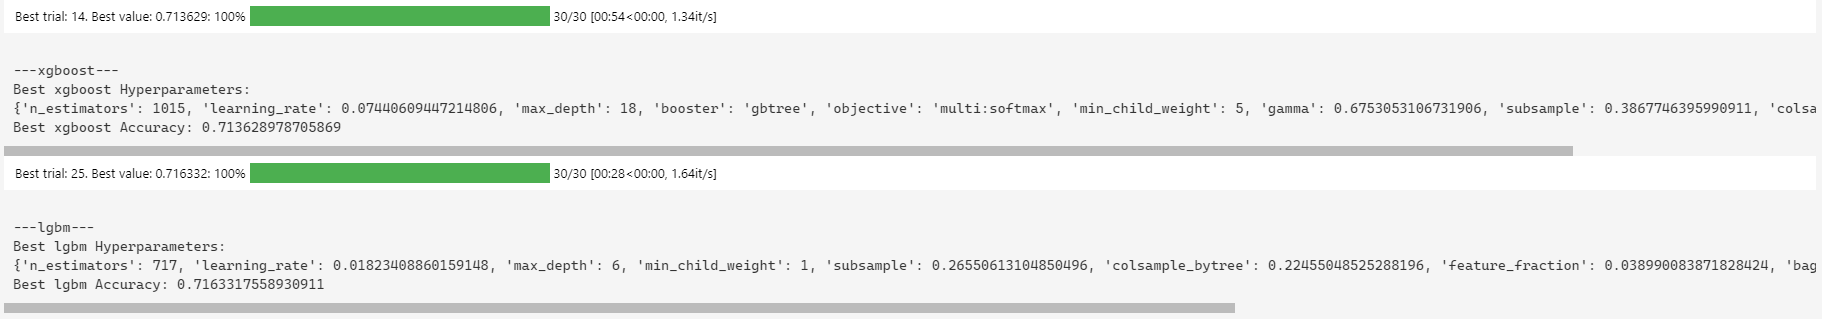

<div style="border-radius: 10px; border: #0ea5e9 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>🖊️ Note :</b> Increasing the <code>n_trials</code> parameter in Optuna allows for a more extensive exploration of the possible combinations of hyperparameters within the Optuna feature space. However, it is essential to be aware that a higher value of n_trials will consume a considerable amount of time. For demonstration purposes, the n_trials value is set to a lower value. We highly recommend using a larger value for n_trials (e.g., 100 to 1000) based on the available computational resources, which will provide a better opportunity to find optimal hyperparameter settings.
</div>

In [ ]:
#best_hyperparmeters_xgb_optuna = best_model[0]
#best_hyperparmeters_lgbm_optuna = best_model[1]

best_hyperparmeters_xgb = {'n_estimators': 839, 'learning_rate': 0.04782334291681709, 'max_depth': 5, 'booster': 'gbtree', 'objective': 'multi:softmax', 'min_child_weight': 2, 
                           'gamma': 0.1877970474083254, 'subsample': 0.526615991664147, 'colsample_bytree': 0.044269535458365206}

best_hyperparmeters_lgbm = {'n_estimators': 414, 'learning_rate': 0.08989781727278148, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.6469963601342329, 
                            'colsample_bytree': 0.4189648750521065, 'feature_fraction': 0.04890191441322272, 'bagging_fraction': 0.6785591761317694, 'verbose':-1, 
                            'lambda_l1': 0.6762149999928689, 'lambda_l2': 0.5553714511272727}

best_hyperparmeters_xgb_1 = {'n_estimators': 492, 'learning_rate': 0.08985171784837719, 'max_depth': 9, 'booster': 'gbtree', 'objective': 'multi:softmax', 'min_child_weight': 2, 'gamma': 0.5182920590849106, 
                             'subsample': 0.6279262509645042, 'colsample_bytree': 0.053247117433651375}

best_hyperparmeters_lgbm_1 = {'n_estimators': 408, 'learning_rate': 0.04741582020950681, 'max_depth': 15, 'min_child_weight': 3, 
                              'subsample': 0.3191799360962958, 'colsample_bytree': 0.17684572195568699, 'feature_fraction': 0.04252207272700393, 
                              'bagging_fraction': 0.7686067678551599, 'verbose':-1, 'lambda_l1': 0.8548525381340649, 
                              'lambda_l2': 0.11189837738466817}

<div style="border-radius: 10px; border: #0ea5e9 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>🖊️ Note :</b> After running Optuna to find the best hyperparameters for different models, the best parameter values for each model are stored in the user define <code>model_hyperparameters</code> list, as described above. These values are then mapped to variables for future use.
<br><br>
Notably, <b>best_hyperparameters_xgb_optuna</b> and <b>best_hyperparameters_lgbm_optuna</b> were obtained using a relatively small number of trials, and thus, they are excluded from further use.
<br><br>
On the other hand, <b>best_hyperparameters_xgb</b>, <b>best_hyperparameters_lgbm</b>, <b>best_hyperparameters_xgb_1</b>, and <b>best_hyperparameters_lgbm_1</b> were derived from a more extensive search with 300 trials, resulting in improved accuracy. These values are available for further utilization.
</div>

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #007fd4">Voting Classifier</p>

<div style="border-radius: 6px; border: #004ed4 solid; padding: 26px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>📚 VotingClassifier :</b> It is a technique that combines the predictions from multiple base classifiers to make a final prediction. The idea behind a voting classifier is to leverage the diversity of multiple models to improve the overall predictive accuracy. This is particularly useful when the base classifiers have different strengths and weaknesses. By combining them, the ensemble can mitigate the weaknesses of individual models and yield better overall performance.
<br><br>
There are two main types of voting classifiers:
<br><br>
<ul>
    <li><b>Hard Voting Classifier :</b> In a hard voting classifier, each base classifier predicts a class label, and the class that receives the majority of the votes is selected as the final prediction.</li>
    <br>
    <li><b>Soft Voting Classifier :</b> In a soft voting classifier, each base classifier calculates the probability or confidence score associated with its prediction for a given class label. These probabilities are then averaged for each class label, and the class with the highest average probability is selected as the final prediction.</li>
</ul>
</div>

In [ ]:
models = [
    ('XGB_best_model', XGBClassifier(**best_hyperparmeters_xgb)),
    ('LGBM_best_model', LGBMClassifier(**best_hyperparmeters_lgbm)),
    ('XGB_best_model_1', XGBClassifier(**best_hyperparmeters_xgb_1)),
    ('LGBM_best_model_1', LGBMClassifier(**best_hyperparmeters_lgbm_1)),
]

In [ ]:
# Create a Voting Classifier with soft voting.
voting_classifier = VotingClassifier(estimators=models, voting='soft')

In [ ]:
# Fit the Voting Classifier on the training data.
voting_classifier.fit(X_preprocessed_pipeline1, y,)

In [ ]:
cv_scores = cross_val_score(voting_classifier, X_preprocessed_pipeline1, y, cv=RepStratFold)

mean_cv_accuracy = cv_scores.mean()
std_cv_accuracy = cv_scores.std()
print(f'\033[32m Ensemble Model RepeatedStratified Cross-Validation Accuracy (Mean): {mean_cv_accuracy:.2f}')
print(f'\033[32m Ensemble Model RepeatedStratified Cross-Validation Accuracy (Standard deviation): {std_cv_accuracy:.2f}')

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #007fd4">Confusion Matrices</p>

<div style="border-radius: 6px; border: #004ed4 solid; padding: 26px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>📚 Confusion Matrices :</b> This matrices are a valuable tool for assessing the performance of classification models, helping to understand the strengths and weaknesses of the model by comparing its predictions to the actual ground truth.
</div>

In [ ]:
predicted_voting_classifier = cross_val_predict(voting_classifier, X_preprocessed_pipeline1, y)
predicted_lgbm_classifier = cross_val_predict(LGBMClassifier(**best_hyperparmeters_lgbm_1), X_preprocessed_pipeline1, y)

In [ ]:
conf_matrix_voting_classifier = confusion_matrix(y, predicted_voting_classifier)
conf_matrix_lgbm_classifier = confusion_matrix(y, predicted_lgbm_classifier)

plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
sns.heatmap(conf_matrix_voting_classifier, annot=True, fmt='d', cmap='Blues', square=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix With Voting Classifier', fontsize=12, fontweight='bold', pad=13)

plt.subplot(1,2,2)
sns.heatmap(conf_matrix_lgbm_classifier, annot=True, fmt='d', cmap='Blues', square=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix With LGBM Classifier', fontsize=12, fontweight='bold', pad=13)

plt.show()

<div style="border-radius: 10px; border: #0ea5e9 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>🖊️ Note :</b> The primary metrics of interest in a multi-class confusion matrix include True Positives (TP) and False Positives (FP). These metrics are used to calculate various performance measures for each class.
<br>
<ul>
    <li><b>True Positives (TP) :</b> The number of instances correctly classified for each class.</li>
    <li><b>False Positives (FP) :</b> The number of instances incorrectly classified as a particular class when they belong to other classes.</li>
</ul>
In the chart, when the same class labels are found in both axis values, this contains True Positives (TP), while others are False Positives (FP), contains the number of instances incorrectly classified.
</div>

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #007fd4">Submission</p>

<div style="border-radius: 10px; border: #0ea5e9 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>🖊️ Note :</b> To improve the model, consider the following strategies:
<br>
<ul>
    <li>Use LabelEncoder in place of OneHotEncoder.</li>
    <li>Use Resampling techniques to address class imbalance.</li>
    <li>Utilize Optuna to select suitable class weights during hyperparameter tuning.</li>
</ul>
</div>

In [ ]:
y_pred_best = voting_classifier.predict(X_test_preprocessed_pipeline1)

In [ ]:
df_submission = df_test[['id']].copy()

In [ ]:
df_submission['outcome'] = y_pred_best
df_submission['outcome'] = df_submission['outcome'].map({2:'lived',1:'euthanized',0:'died'})

In [ ]:
df_submission.to_csv("/kaggle/working/submit.csv", index=False)